In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import obspy
from obspy.core.utcdatetime import UTCDateTime

from pyproj import Proj, transform

from scipy import signal
from scipy.interpolate import griddata

import ray
import multiprocessing

import os

n_cpus = multiprocessing.cpu_count()

In [2]:
def lag_finder(y1, y2, channel=0):
    if  type(y1) != obspy.core.stream.Trace:
        y1 = y1[channel]
        y2 = y2[channel]
    
    n = len(y1)
    sr = int(y1.stats.sampling_rate)
    corr = signal.correlate(y2, y1, mode='same') / np.sqrt(signal.correlate(y1, y1, mode='same')[int(n/2)] * signal.correlate(y2, y2, mode='same')[int(n/2)])

    delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
    delay = delay_arr[np.argmax(corr)]
    return delay, corr

def calc_t_est(indexes, delta_t):
    n = len(np.unique(indexes))
    delta_t = np.append(delta_t, 0)
    array = (np.asarray([[i[0][-1] for i in indexes]], dtype='object') + \
              np.asarray([[i[1][-1] for i in indexes]], dtype='object'))[0]
#     print(array)
    coef = np.zeros((int(n*(n-1)/2+1), n))
    coef[[i for i in range(0,len(coef)-1)],[int(j[0])-1 for j in array]]  =  1
    coef[[i for i in range(0,len(coef)-1)],[int(j[1])-1 for j in array]]  = -1
    coef[-1,:] = 1
#     print(np.asmatrix(coef).T)
#     print(np.asmatrix(delta_t).T)
    return np.asarray((1/n)*(np.asmatrix(coef).T)*np.asmatrix(delta_t).T)

In [3]:
def plot_correlation(row,column,st1,st2):
    ax = fig.add_subplot(spec[row, column], sharey=ax8)
    delay, corr = lag_finder(st1, st2)
    ax.plot(corr, label=st1.stats.location + '->' + st2.stats.location + ' ' + str(delay*1000) + ' ms')
    ax.legend(fontsize=8)
    return delay

def plot_waveform(row, column,st0_win,color,channel=0, shareax=False):
    if shareax:
        ax = fig.add_subplot(spec[row:row+3, column],sharex=shareax, sharey=shareax)
    else:
        ax = fig.add_subplot(spec[row:row+3, column])
        
    if st0_win[0].stats.station != 'HYP':
        name = st0_win[channel].stats.network + '.' + st0_win[channel].stats.station
    else:
        name = st0_win[channel].stats.station + '.' + st0_win[channel].stats.location
    ax.plot(st0_win[channel].times(), st0_win[channel].data, label=name, color=color)
    ax.set_ylim(ymin=-1, ymax=1)
    ax.legend()
    return ax

def data_selection(event, window, st0, st, hyp, metlift_full, cc_ff):
    window_length = pd.Timedelta(seconds=window)
    starttime = shots['ShotTime'][shots['LocCode'] == event].values[0]-window_length/2 
    endtime = starttime+(window_length)

    # Data selection
    st0_win = st0.copy().trim(starttime=UTCDateTime(starttime), endtime=UTCDateTime(endtime))
    st_win  = st.copy().trim(starttime=UTCDateTime(starttime), endtime=UTCDateTime(endtime))
    hyp_win = hyp.copy().trim(starttime=UTCDateTime(starttime), endtime=UTCDateTime(endtime))

    metlift  = metlift_full[metlift_full['timestamp'].between(starttime.round(freq='min'),endtime.round(freq='min'))]
    cc_ff    = cc_ff_full[cc_ff_full['timestamp'].between(starttime,endtime)]
    return window_length, starttime, endtime, st0_win, st_win, hyp_win, metlift, cc_ff

def data_processing(st_win, st0_win, hyp_win, freqmin, freqmax):
    st0_win.detrend().normalize();
    st_win.detrend().normalize();
    st0_win.taper(0.1);
    st_win.taper(0.1);
    st0_win.filter('bandpass', freqmin=freqmin, freqmax=freqmax);
    st_win.filter('bandpass', freqmin=freqmin, freqmax=freqmax);
    if len(hyp_win) != 0:
        for i in range(0,4):
            hyp_win[i].detrend()
        hyp_win.normalize();
        hyp_win.taper(0.1);
        hyp_win.filter('bandpass', freqmin=freqmin, freqmax=freqmax);

In [4]:
### Shots processing ###
p = Proj(init="epsg:32633", proj='utm', zone=33)

shots = pd.read_csv('Ground_coupling/coordinates/shots_from_doc_UTM.csv')
shots['Seconds'] = shots['Seconds'].replace(np.nan,0)
shots['Seconds'] = shots['Seconds'].apply(lambda x: pd.Timedelta(seconds=x))
shots['ShotTime'] = pd.to_datetime('2019-05-14 '+shots['ShotTime'],utc=True) + shots['Seconds']
shots['IgnitionTime'] = pd.to_datetime('2019-05-14 '+shots['IgnitionTime'],utc=True)
shots['LiftoffTime'] = pd.to_datetime('2019-05-14 '+shots['LiftoffTime'],utc=True)

shots['lon'], shots['lat'] = p(shots['UTM_X'].values, shots['UTM_Y'].values,inverse=True)
shots.to_pickle('shots.pkl')

### Load data

In [16]:
shots

IgnitionTime LiftoffTime                         ShotTime  \
0                        NaT         NaT 2019-05-14 12:47:07.300000+00:00   
1                        NaT         NaT 2019-05-14 12:47:10.500000+00:00   
2                        NaT         NaT 2019-05-14 12:47:13.200000+00:00   
3                        NaT         NaT 2019-05-14 12:47:15.700000+00:00   
4                        NaT         NaT 2019-05-14 12:45:13.800000+00:00   
5                        NaT         NaT 2019-05-14 12:45:16.200000+00:00   
6                        NaT         NaT 2019-05-14 12:45:19.400000+00:00   
7                        NaT         NaT 2019-05-14 12:45:22.700000+00:00   
8                        NaT         NaT 2019-05-14 12:49:35.700000+00:00   
9                        NaT         NaT 2019-05-14 12:49:38.700000+00:00   
10                       NaT         NaT 2019-05-14 12:49:41.700000+00:00   
11                       NaT         NaT        2019-05-14 12:49:45+00:00   
12                       NaT         NaT 2019-05-14 12:52:06.400000+00:00   
13                       NaT         NaT 2019-05-14 12:52:09.100000+00:00   
14                       NaT         NaT 2019-05-14 12:52:11.800000+00:00   
15                       NaT         NaT 2019-05-14 12:52:14.800000+00:00   
16                       NaT         NaT 2019-05-14 12:53:48.700000+00:00   
17                       NaT         NaT 2019-05-14 12:53:50.700000+00:00   
18                       NaT         NaT 2019-05-14 12:56:53.500000+00:00   
19                       NaT         NaT 2019-05-14 12:56:56.100000+00:00   
20                       NaT         NaT 2019-05-14 12:56:59.100000+00:00   
21                       NaT         NaT 2019-05-14 12:57:02.100000+00:00   
22                       NaT         NaT 2019-05-14 12:57:08.200000+00:00   
23                       NaT         NaT 2019-05-14 12:57:11.300000+00:00   
24                       NaT         NaT 2019-05-14 12:57:14.500000+00:00   
25                       NaT         NaT 2019-05-14 12:57:17.300000+00:00   
26                       NaT         NaT 2019-05-14 12:57:20.300000+00:00   
27                       NaT         NaT 2019-05-14 12:58:38.600000+00:00   
28                       NaT         NaT 2019-05-14 12:58:41.300000+00:00   
29                       NaT         NaT        2019-05-14 12:58:44+00:00   
..                       ...         ...                              ...   
44                       NaT         NaT 2019-05-14 14:23:50.200000+00:00   
45                       NaT         NaT 2019-05-14 14:24:08.200000+00:00   
46                       NaT         NaT        2019-05-14 14:25:02+00:00   
47                       NaT         NaT 2019-05-14 14:25:36.800000+00:00   
48 2019-05-14 13:21:53+00:00         NaT 2019-05-14 13:21:56.800000+00:00   
49 2019-05-14 13:23:38+00:00         NaT 2019-05-14 13:23:42.250000+00:00   
50 2019-05-14 13:24:35+00:00         NaT        2019-05-14 13:24:42+00:00   
51 2019-05-14 13:25:54+00:00         NaT 2019-05-14 13:26:02.100000+00:00   
52 2019-05-14 13:26:26+00:00         NaT 2019-05-14 13:26:33.400000+00:00   
53 2019-05-14 13:28:08+00:00         NaT 2019-05-14 13:28:14.250000+00:00   
54 2019-05-14 13:35:22+00:00         NaT 2019-05-14 13:35:27.200000+00:00   
55 2019-05-14 13:36:07+00:00         NaT 2019-05-14 13:36:12.500000+00:00   
56 2019-05-14 13:36:35+00:00         NaT 2019-05-14 13:36:42.100000+00:00   
57 2019-05-14 13:37:01+00:00         NaT 2019-05-14 13:37:08.500000+00:00   
58 2019-05-14 13:37:24+00:00         NaT 2019-05-14 13:37:32.400000+00:00   
59 2019-05-14 13:37:47+00:00         NaT 2019-05-14 13:37:54.900000+00:00   
60 2019-05-14 13:40:33+00:00         NaT 2019-05-14 13:40:38.250000+00:00   
61 2019-05-14 13:41:05+00:00         NaT 2019-05-14 13:41:09.750000+00:00   
62 2019-05-14 13:41:48+00:00         NaT        2019-05-14 13:41:56+00:00   
63 2019-05-14 13:42:12+00:00         NaT 2019-05-14 13:42:18.500000+00:00   
64 2019-05-1

In [5]:
path = 'Ground_coupling/'
inv_ff = obspy.read_inventory(path+'nodes/nodes_metadata.xml')
st_list = os.listdir(path+'nodes/FF_Vel/')

In [6]:
## Tables
shots         = pd.read_pickle('shots.pkl')              # Load shots
metlift_full  = pd.read_pickle('MetLift.pkl')            # Load meteo
cc_ff_full    = pd.read_pickle('cross_correlations.pkl') # Load Cross_correlations Fair Fields
cc_hyp_full   = pd.read_pickle('cross_correlations_hyperions.pkl') # Load Cross_correlations Hyperions

## Records
st0 = obspy.read('Ground_coupling/nodes/FF_Vel/2019_134_R1_1VEL.mseed') # Seismic R1.1
hyp = obspy.read('Ground_coupling/hyperions/hyperions_VEL.mseed')       # Hyperions       

### Select and process data

In [17]:
event = 'E3_5'
window = 0.5
freqmin=10
freqmax=200

## Records
station = 'R5_25'
st  = obspy.read('Ground_coupling/nodes/FF_Vel/2019_134_'+station+'VEL.mseed') #Seismic

window_length, starttime, endtime, st0_win, st_win, hyp_win, metlift, cc_ff = data_selection(event, window, st0, st, 
                                                                                    hyp, metlift_full, cc_ff_full)
data_processing(st_win, st0_win, hyp_win, freqmin, freqmax)

### Plot data

In [26]:
for event in shots['LocCode'].values[47:]:
    print(event)
    break

V1_6


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


IndexError: index 0 is out of bounds for axis 0 with size 0

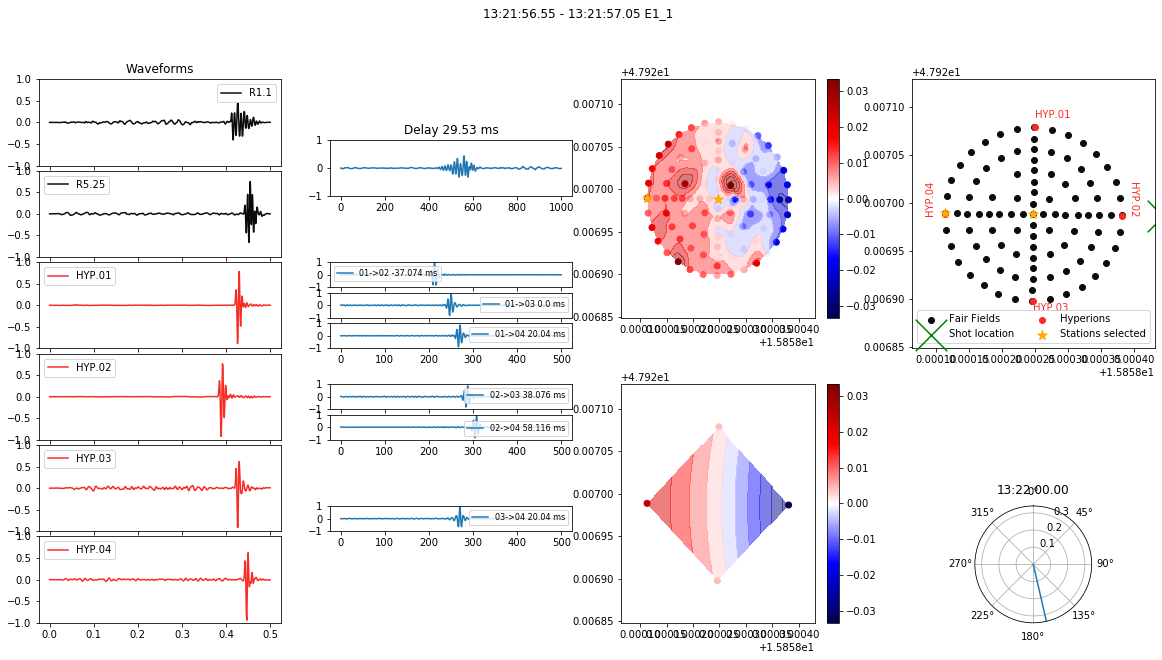

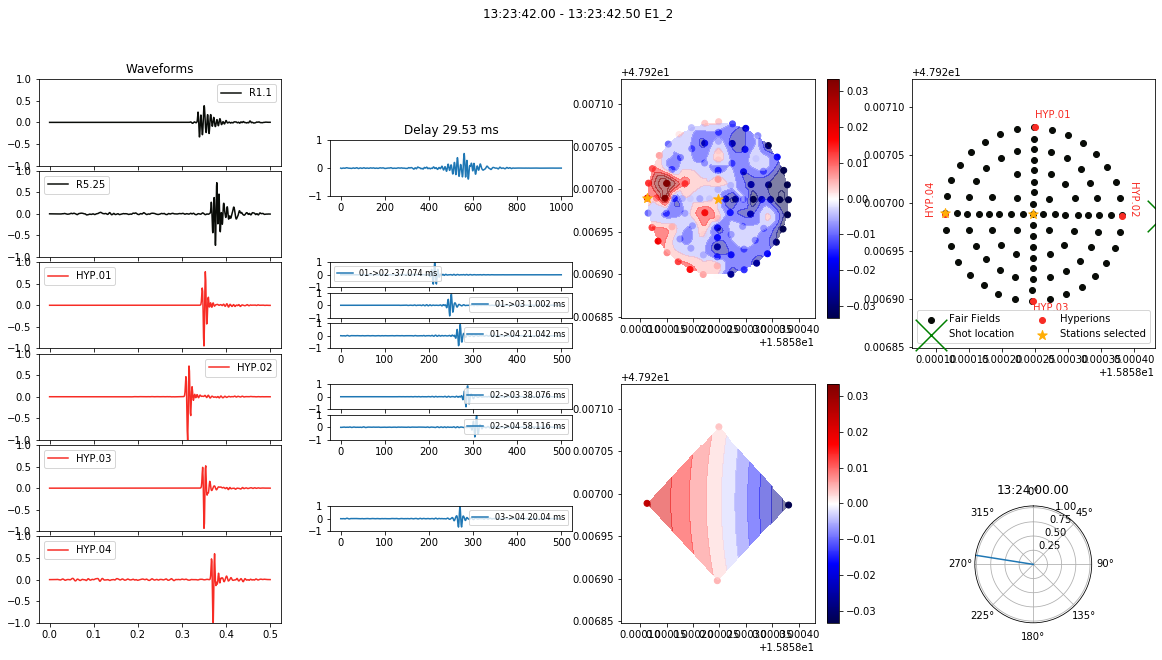

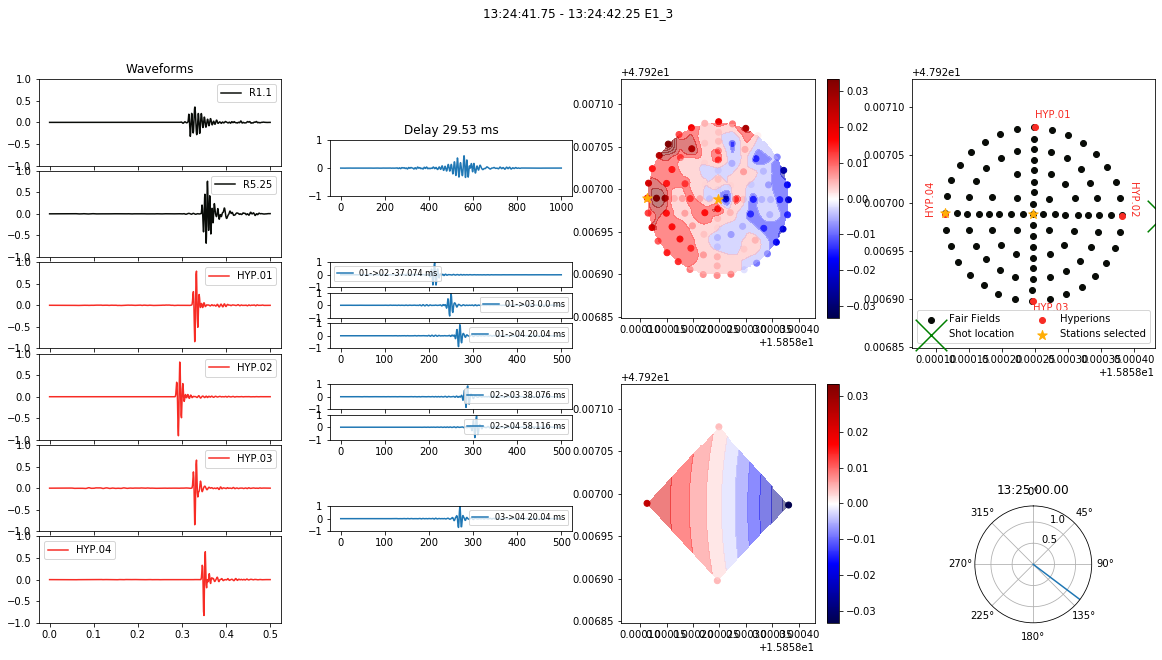

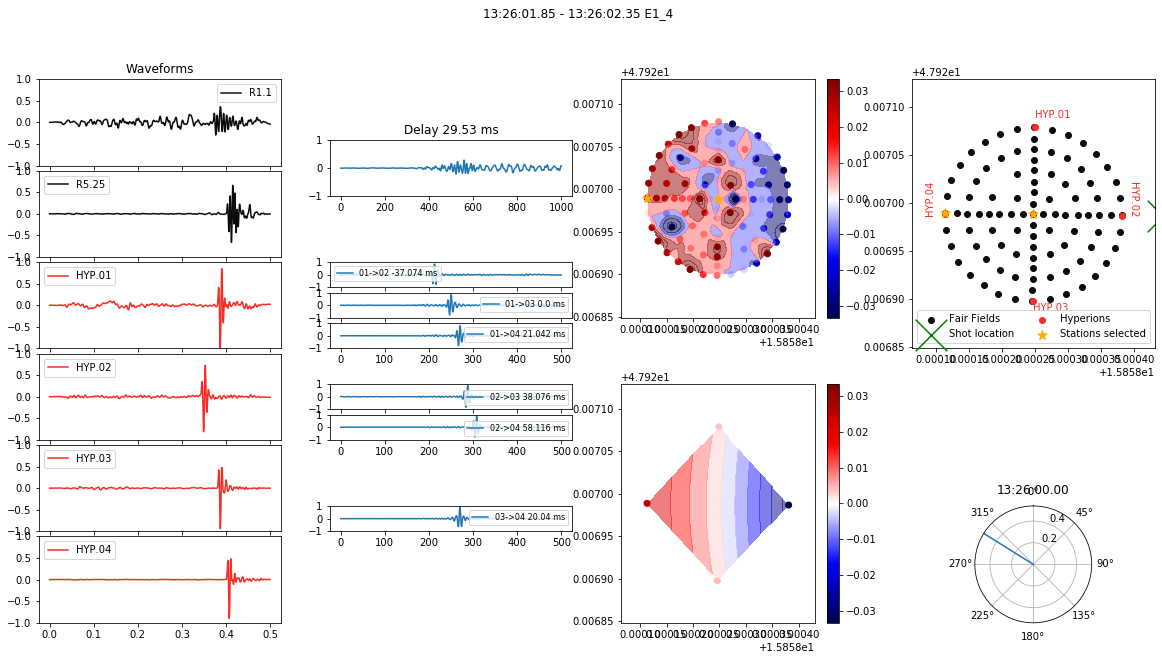

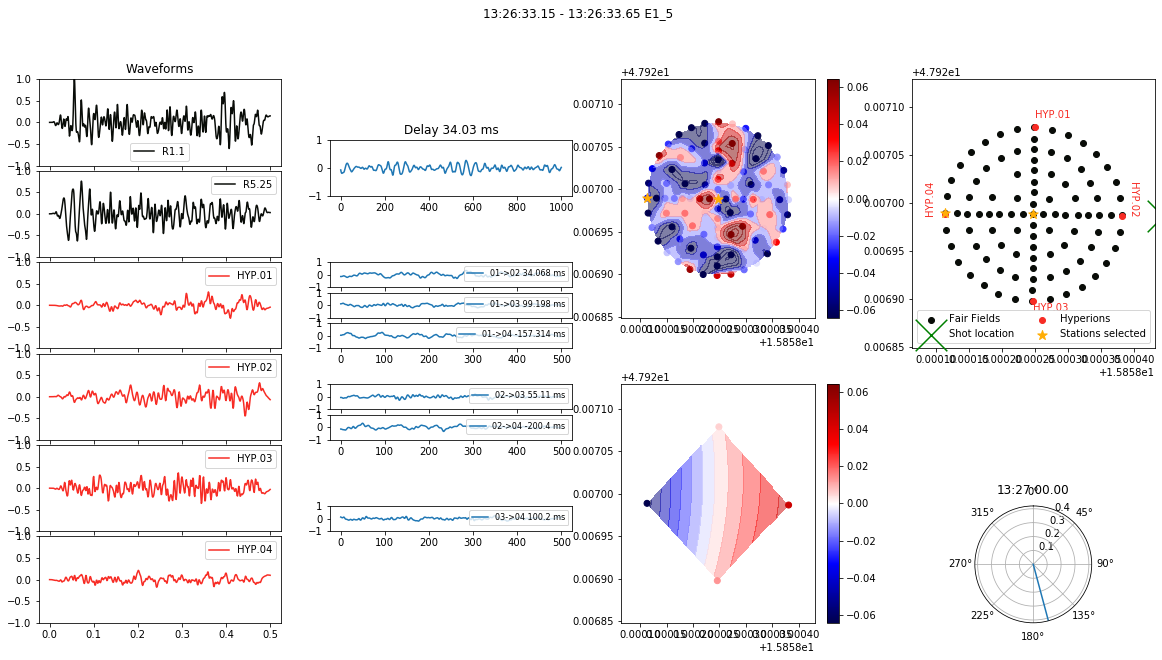

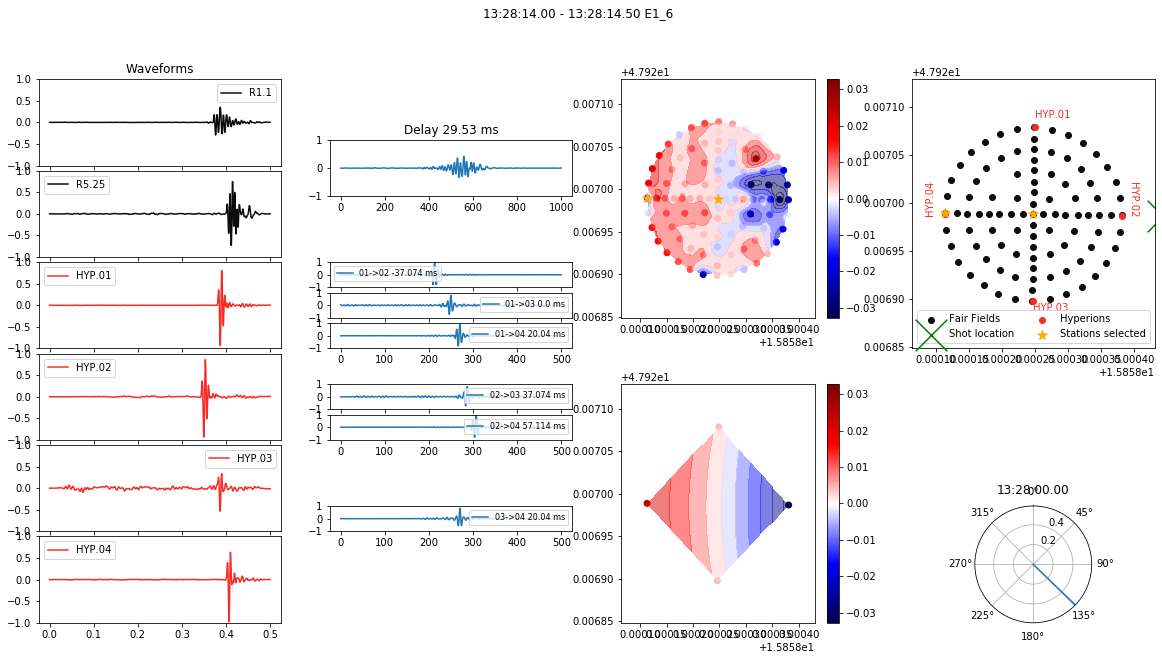

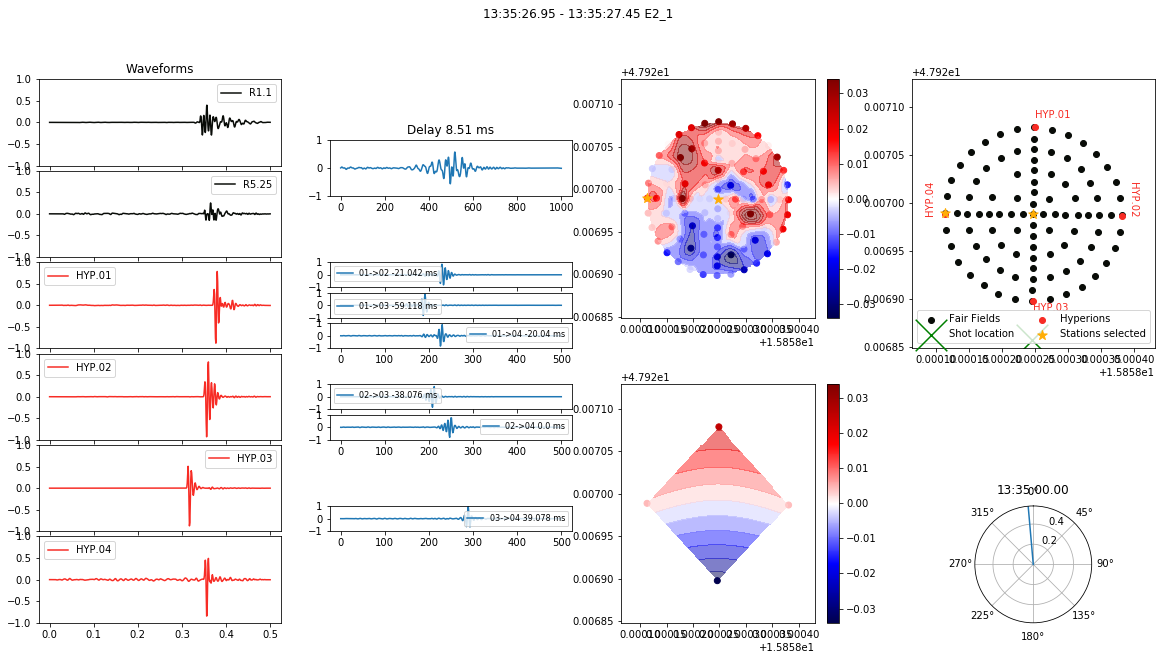

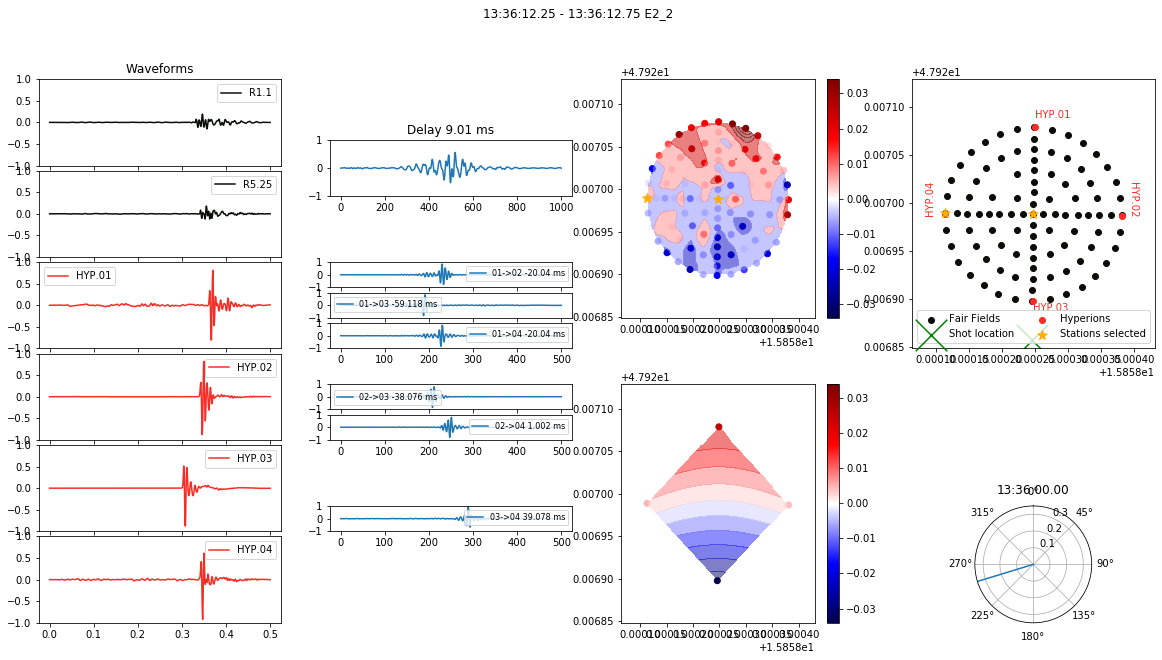

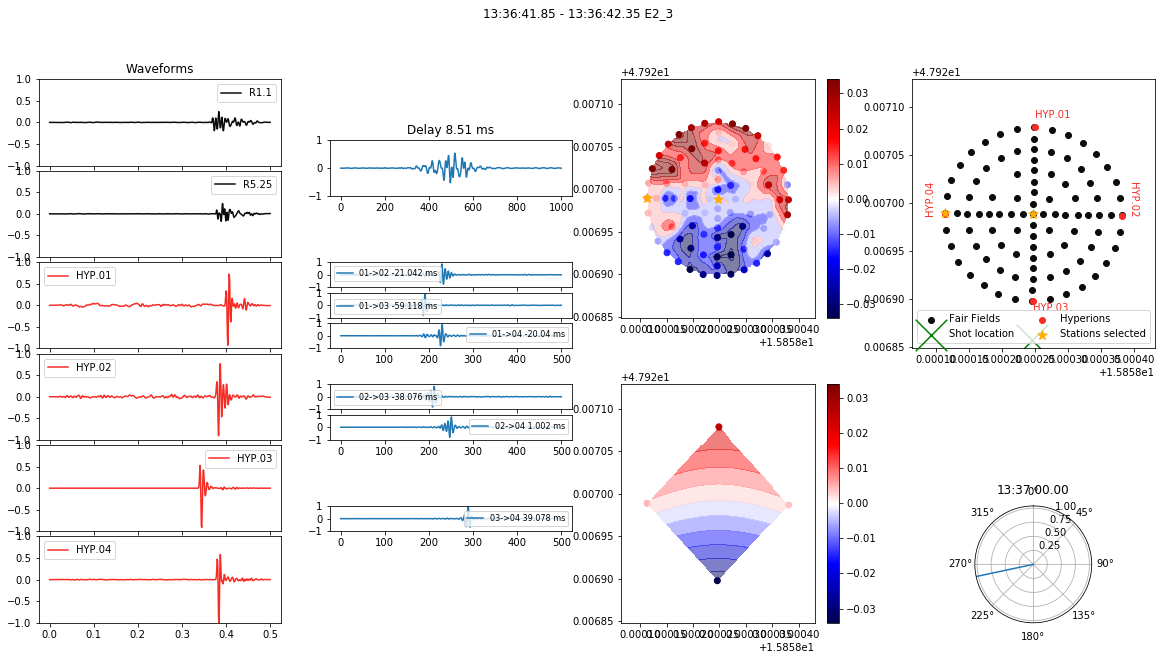

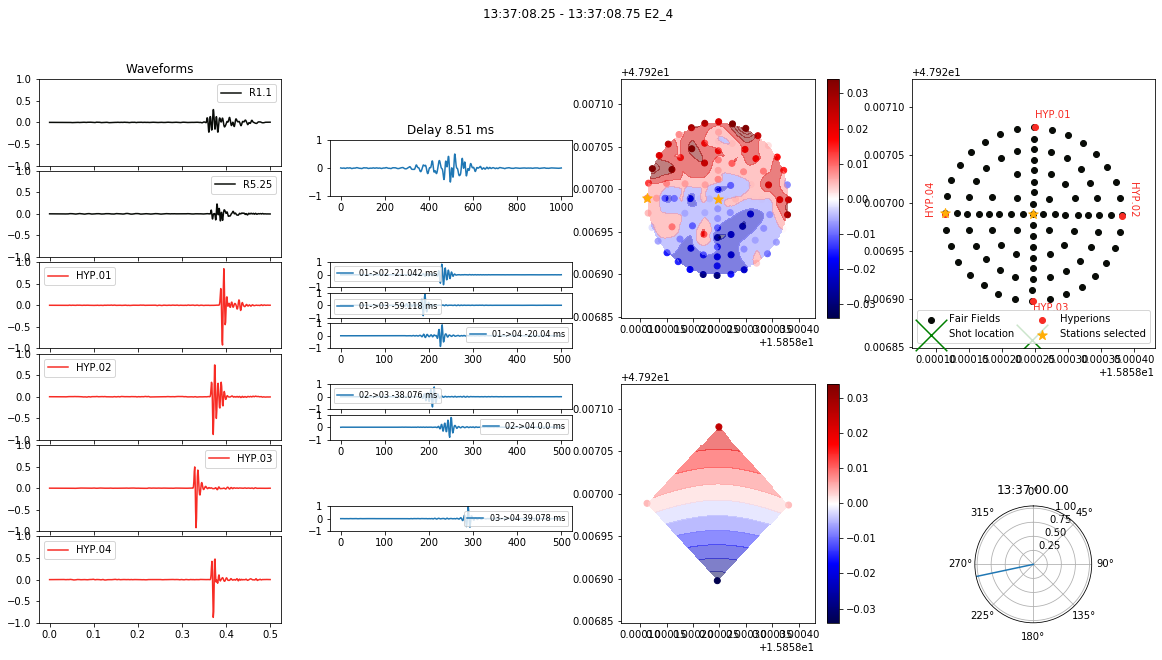

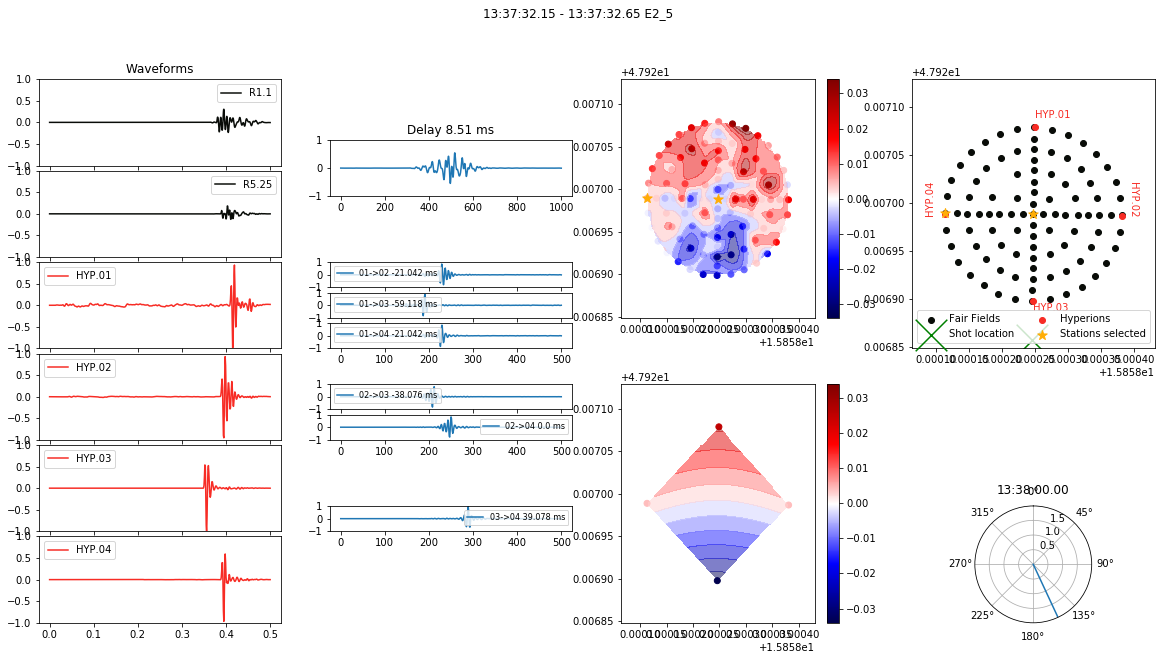

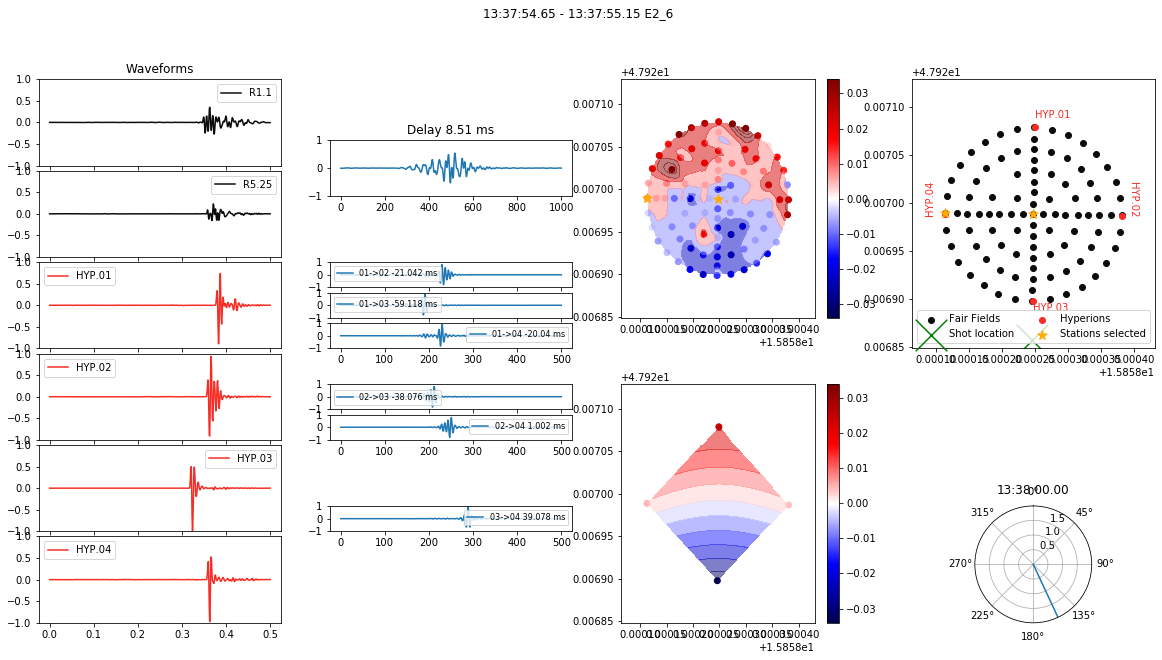

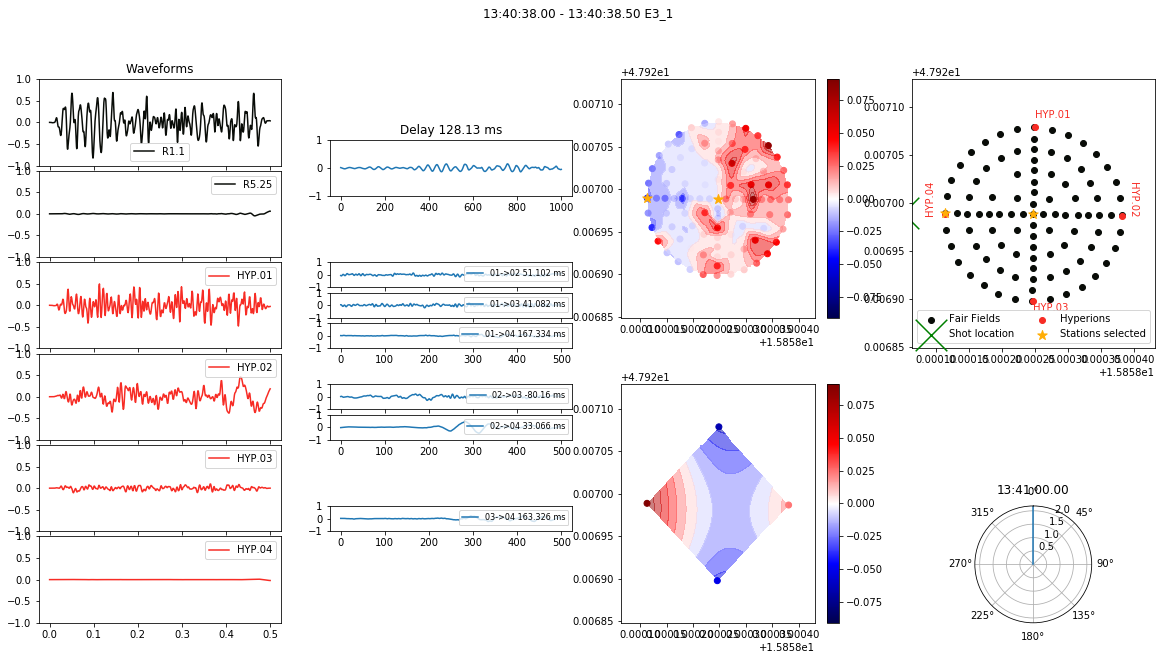

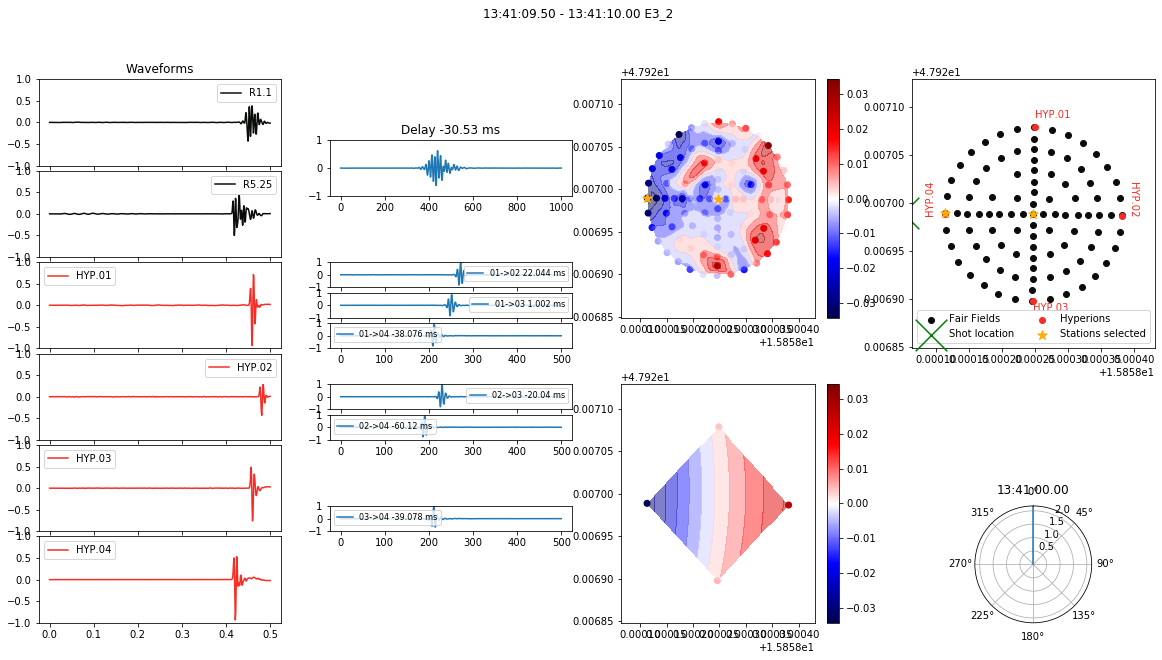

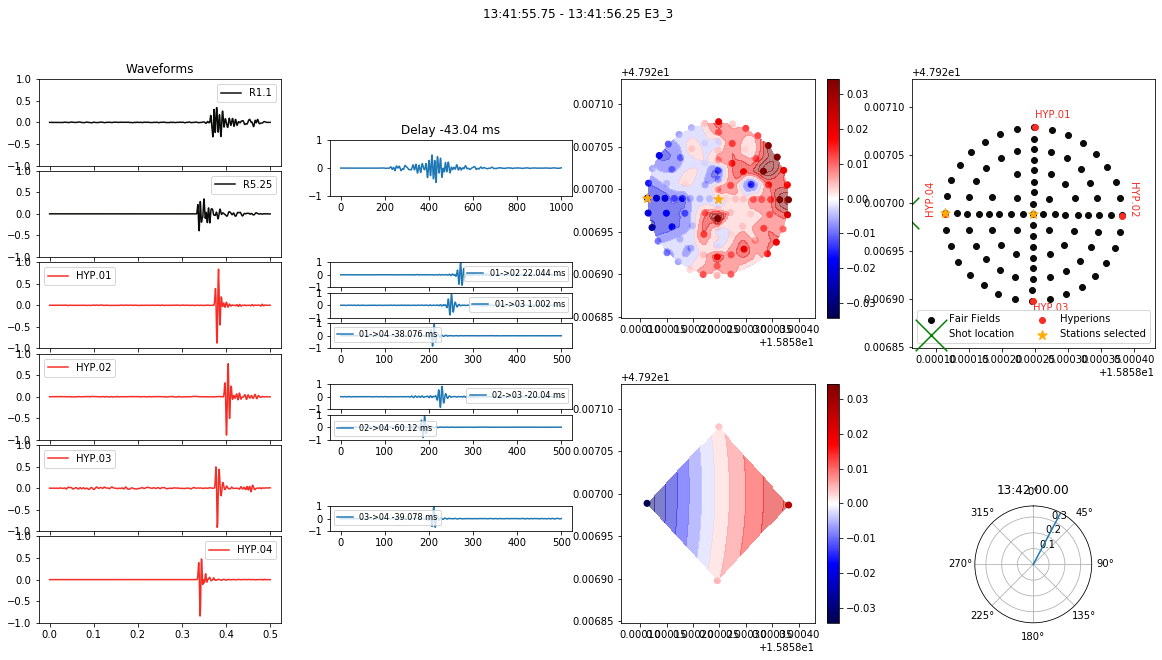

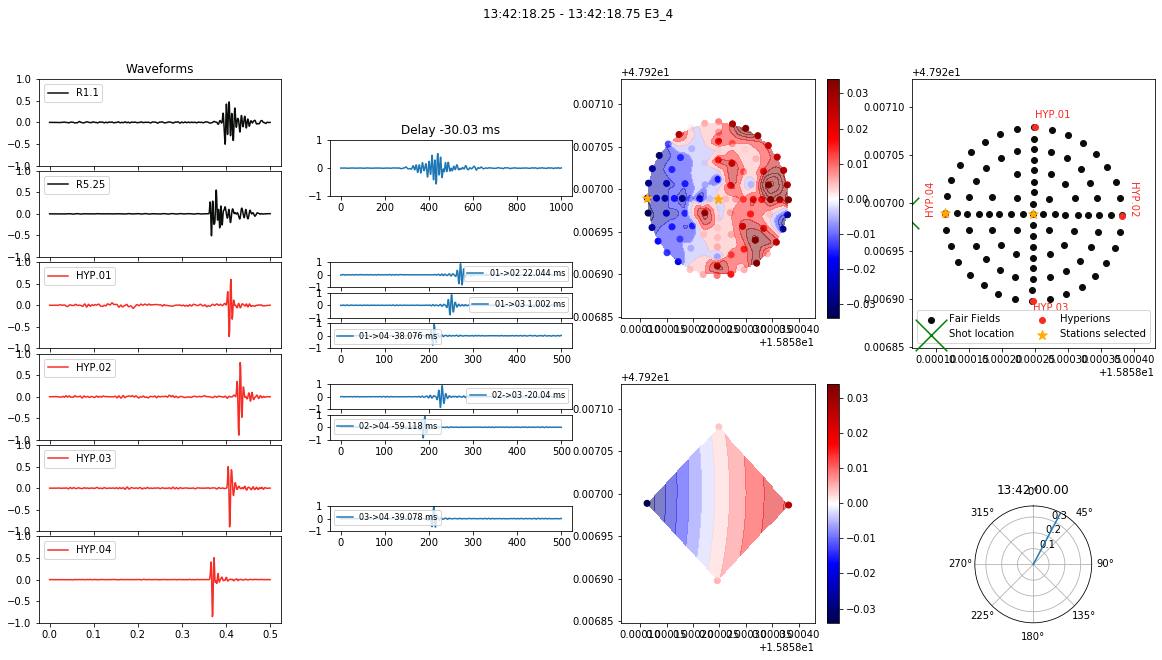

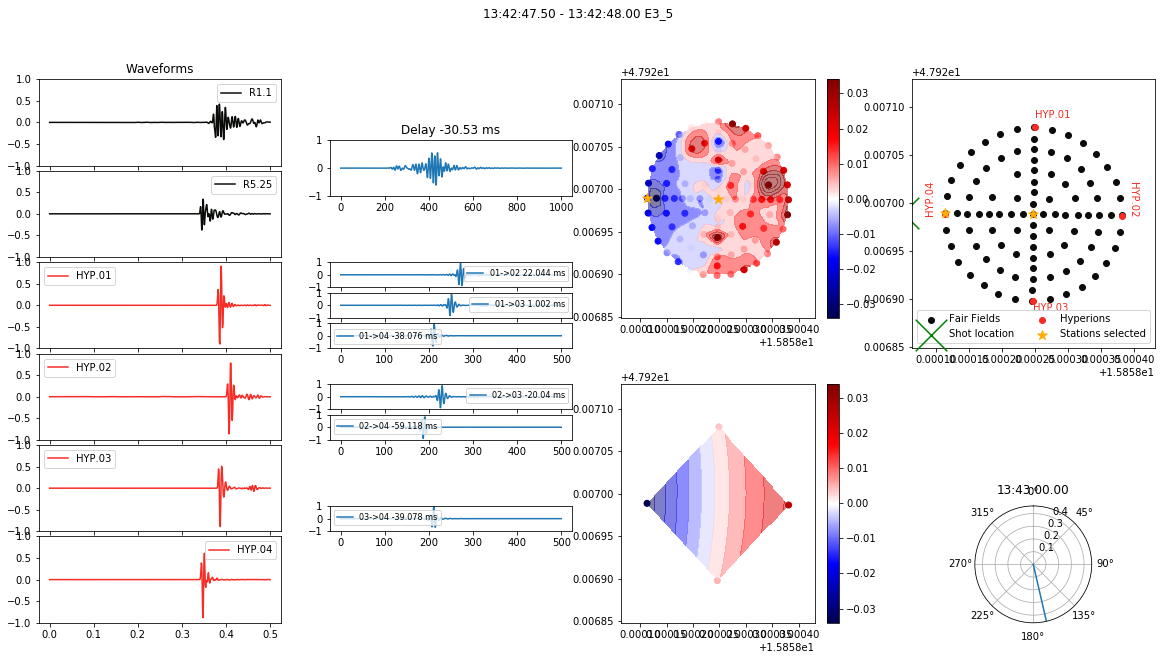

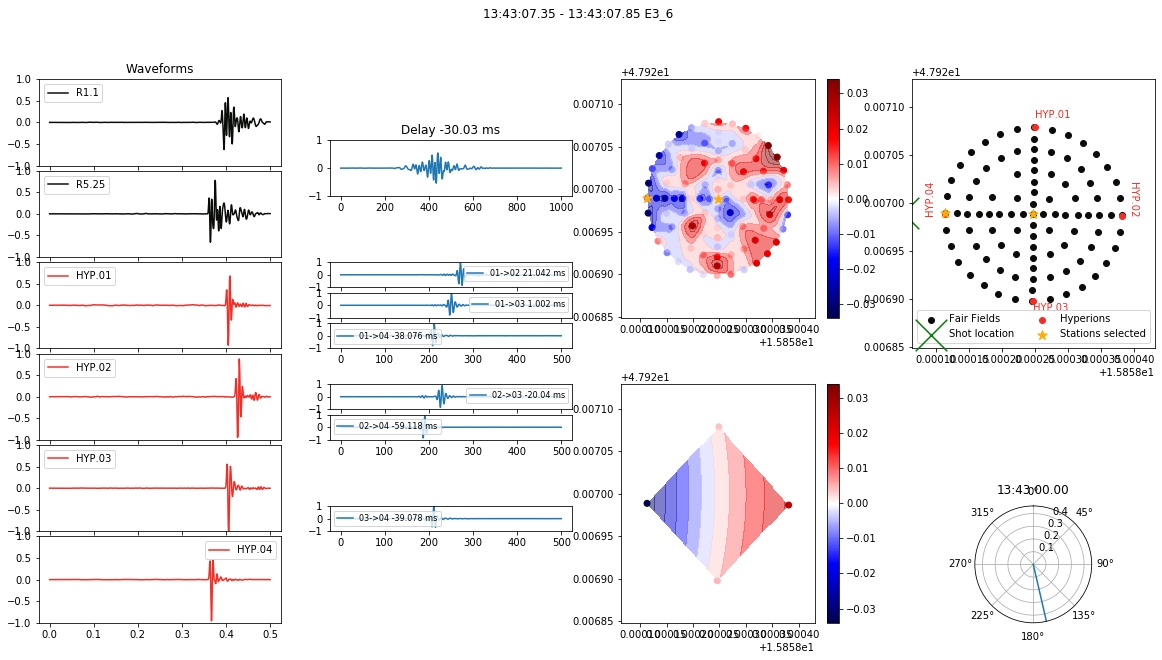

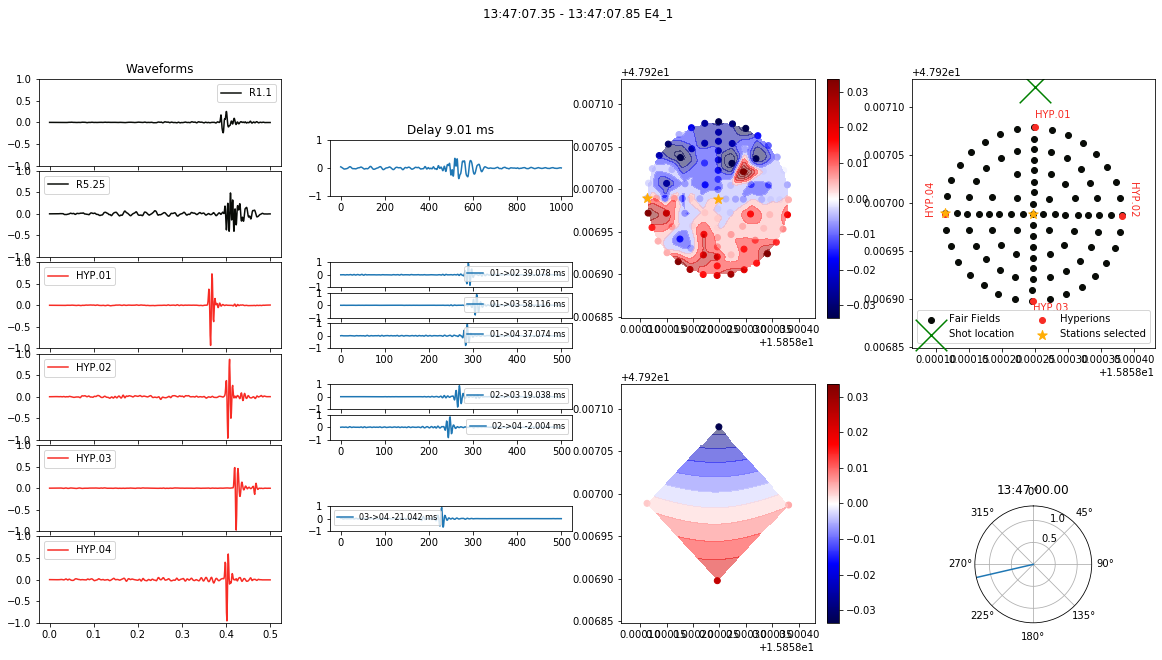

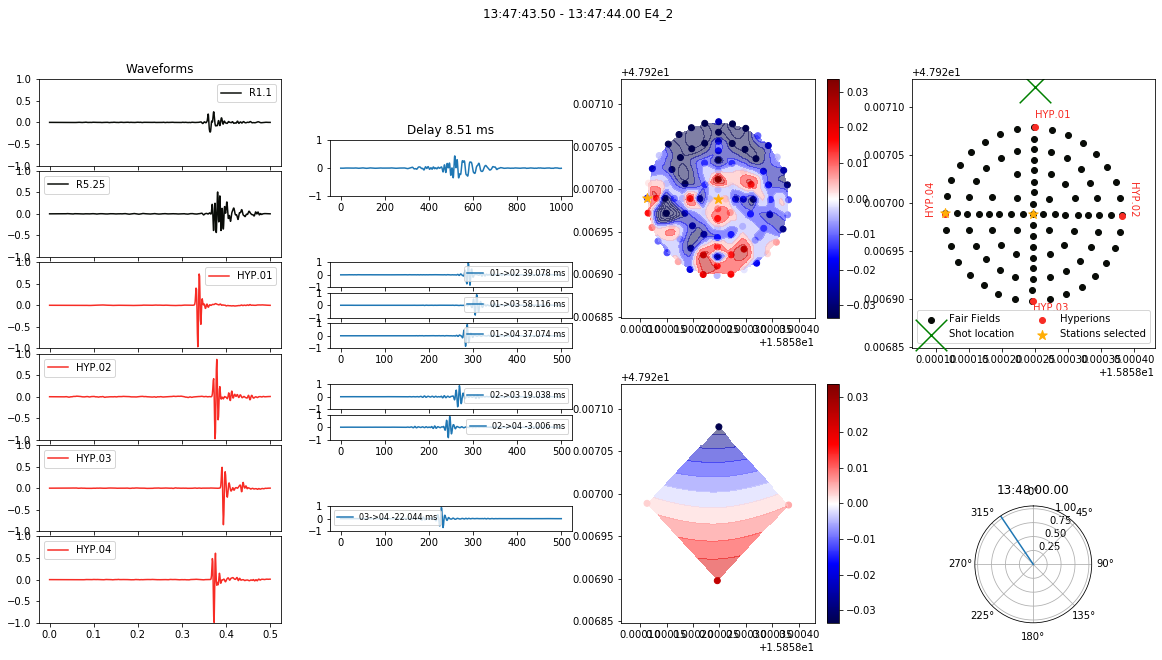

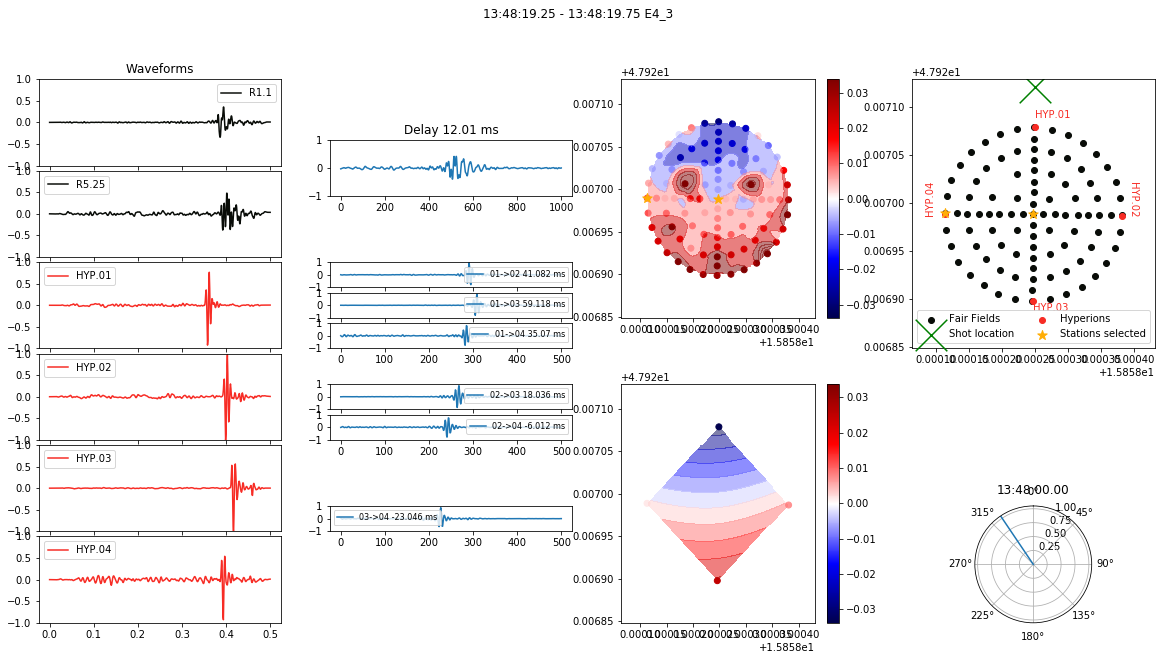

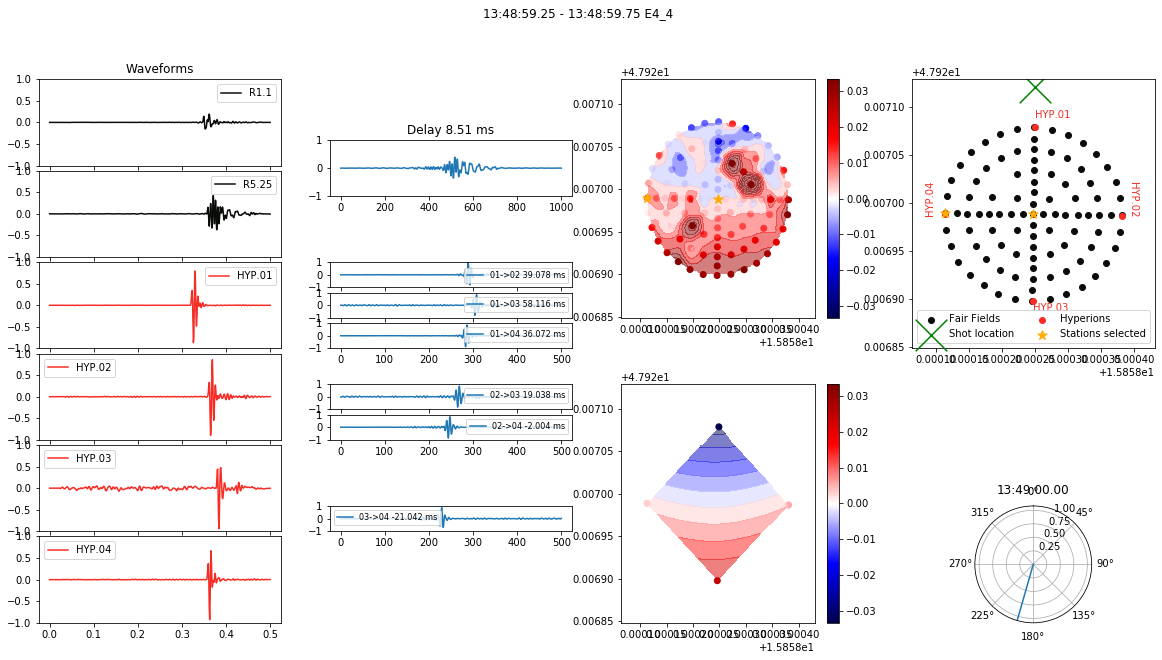

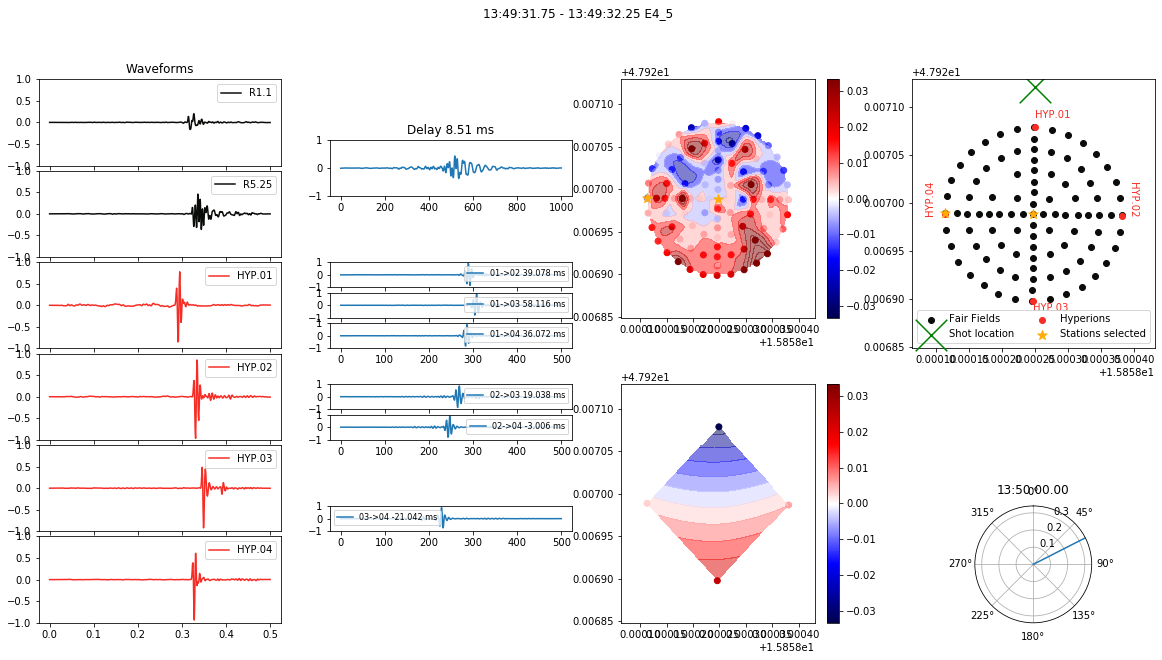

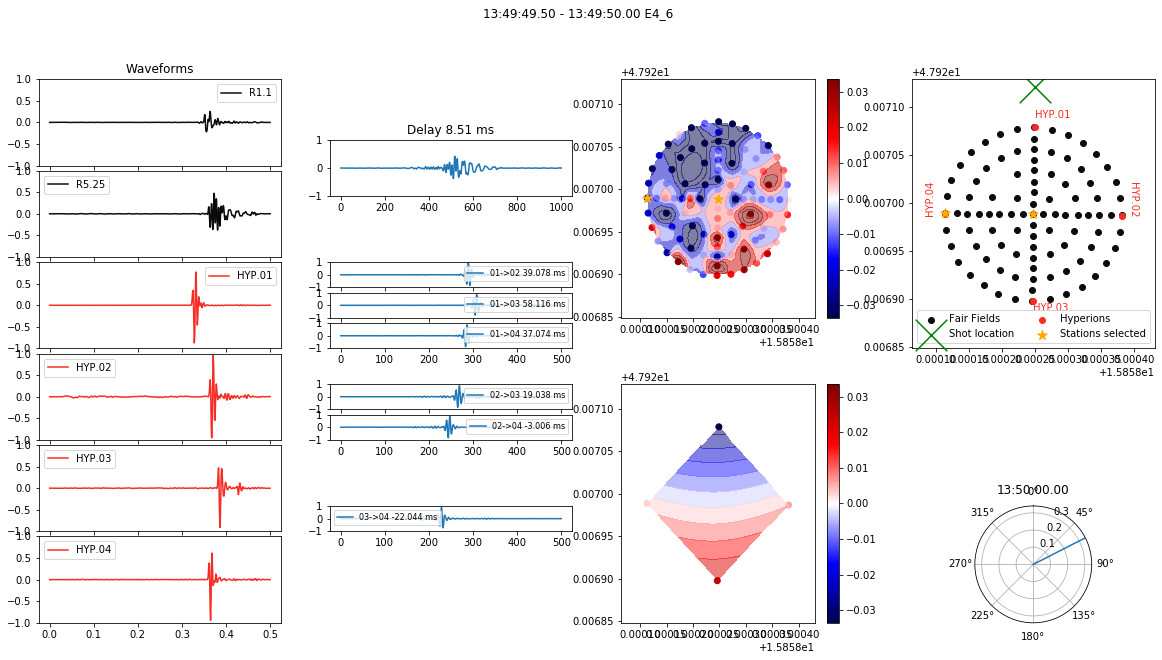

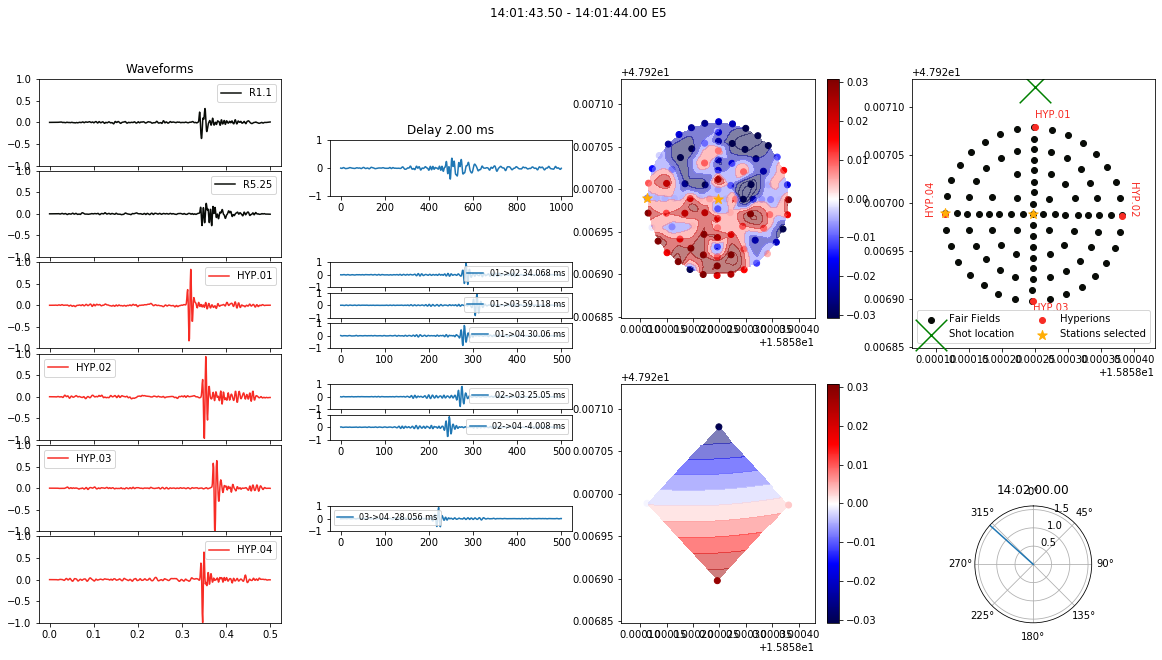

In [29]:
%matplotlib inline

event = 'E3_5'
window = 0.5
freqmin=10
freqmax=200

## Records
station = 'R5_25'
st  = obspy.read('Ground_coupling/nodes/FF_Vel/2019_134_'+station+'VEL.mseed') #Seismic

window_length, starttime, endtime, st0_win, st_win, hyp_win, metlift, cc_ff = data_selection(event, window, st0, st, 
                                                                                    hyp, metlift_full, cc_ff_full)
data_processing(st_win, st0_win, hyp_win, freqmin, freqmax)



channel = 0

c_seismic   = '#090C08'
c_hyp = '#F72C25'
c_shot ='green'
c_stations = '#FFAD05'
cmap = 'seismic'

cc_ff_rings = cc_ff[~cc_ff['station'].isin(['C1.1', 'C1.2', 'C1.3'])]

x_seismic = cc_ff_rings.groupby('station').mean()['lon']
y_seismic = cc_ff_rings.groupby('station').mean()['lat']
z_seismic = np.asarray([np.average(group['delay_Z'], weights=group['corr_Z']) for name, group in 
                        cc_ff_rings.groupby('station')])

x_hyp = cc_hyp_full.groupby('station_from').mean()['lon']
y_hyp = cc_hyp_full.groupby('station_from').mean()['lat']
names_hyp = cc_hyp_full.groupby('station_from').mean().index

x_shot = shots['lon'][shots['LocCode'] == event].values[0]
y_shot = shots['lat'][shots['LocCode'] == event].values[0]

# Create figure
fig = plt.figure(figsize=(20,10))
spec = gridspec.GridSpec(ncols=4, nrows=18, figure=fig)

# Plot waveforms
ax1 = plot_waveform(0, 0, st0_win, color=c_seismic)
ax1.set_title('Waveforms')
ax2 = plot_waveform(3, 0, st_win, color=c_seismic, shareax=ax1)

if len(hyp_win) != 0:
    col = 6
    for channel in range(0,4):
        plot_waveform(col, 0, hyp_win, color=c_hyp, channel=channel)
        col+=3

# Plot reference map
ax7 = fig.add_subplot(spec[:9, 3])
ax7.scatter(x=x_seismic, y=y_seismic, color=c_seismic, label='Fair Fields')
ax7.scatter(x=x_shot,    y=y_shot,    color=c_shot, marker='x', s=1e3, label='Shot location')
ax7.scatter(x=x_hyp,     y=y_hyp,     color=c_hyp, label='Hyperions')
for i in names_hyp:
    if x_hyp[i]>x_seismic['R1.1']+0.00005:
        ax7.text(x=x_hyp[i]+0.00001,y=y_hyp[i], s=i, c=c_hyp, rotation=-90);
    if x_hyp[i]<x_seismic['R1.1']-0.00005:
        ax7.text(x=x_hyp[i]-0.00003,y=y_hyp[i], s=i, c=c_hyp, rotation=90);
    if y_hyp[i]>y_seismic['R1.1']+0.00005:
        ax7.text(x=x_hyp[i],y=y_hyp[i]+0.00001, s=i, c=c_hyp);
    if y_hyp[i]<y_seismic['R1.1']-0.00005:
        ax7.text(x=x_hyp[i],y=y_hyp[i]-0.00001, s=i, c=c_hyp);

ax7.scatter(x=[x_seismic['R1.1'], x_seismic[station.replace('_','.')]], 
            y =[y_seismic['R1.1'], y_seismic[station.replace('_','.')]], 
            color = c_stations, marker="*", label='Stations selected', s=1e2)
ax7.set_xlim(x_seismic.min()-0.00005, x_seismic.max()+0.00005)
ax7.set_ylim(y_seismic.min()-0.00005, y_seismic.max()+0.00005)
ax7.legend(mode="expand", loc=4, ncol=2)

# Compute and plot corelations
ax8 = fig.add_subplot(spec[2:4, 1])
delay, corr = lag_finder(st0_win, st_win)
ax8.plot(corr)
ax8.set_ylim(-1.0,1.0)
ax8.set_title('Delay %.2f ms' % (delay*1000));

if len(hyp_win) != 0:
    delta_t = []
    indexes = []
    row = 6
    for i in range(0,4):
        for j in range(0,4):
            if j != i:
                if [hyp_win[j].stats.location, hyp_win[i].stats.location] not in indexes:
                    indexes.append([hyp_win[i].stats.location, hyp_win[j].stats.location])
                    delay = plot_correlation(row,1,hyp_win[i],hyp_win[j])
                    delta_t.append(delay)
                row+=1
    t_est = -calc_t_est(indexes, delta_t)

    vmax_hyp = np.abs(t_est).max()
    vmin_hyp = -vmax_hyp            

# Plot correlation map - Seismic
vmax_seis = np.abs(z_seismic).max()
vmin_seis = -vmax_seis

ax12 = fig.add_subplot(spec[:8, 2], sharex=ax7, sharey=ax7)
c_bar12 = ax12.scatter(x=x_seismic, y=y_seismic, c=z_seismic, label='Correlation_Z', 
                       cmap=cmap, vmin=vmin_hyp, vmax=vmax_hyp)

xi_seis = np.linspace(x_seismic.min(), x_seismic.max(), 100)
yi_seis  = np.linspace(y_seismic.min(), y_seismic.max(), 100)
zi_seis  = griddata((x_seismic, y_seismic), z_seismic, (xi_seis[None,:], yi_seis[:,None]), method='cubic', rescale=True)
ax12.contourf(xi_seis, yi_seis, zi_seis,10, 
                        cmap=cmap, vmin=vmin_hyp, vmax=vmax_hyp, alpha=0.5)
ax12.scatter(x=[x_seismic['R1.1'], x_seismic[station.replace('_','.')]], 
            y =[y_seismic['R1.1'], y_seismic[station.replace('_','.')]], 
            color = c_stations, marker="*", label='Stations selected', s=1e2)
plt.colorbar(c_bar12)

if len(hyp_win) != 0:
    # Plot correlation map - Hyperions
    ax13 = fig.add_subplot(spec[10:, 2], sharex=ax7, sharey=ax7)
    delays_hyp = [t[0] for t in t_est]

    c_bar13 = ax13.scatter(x=x_hyp, y=y_hyp, c=delays_hyp, vmin=vmin_hyp, vmax=vmax_hyp, label='Hyperions', cmap=cmap)
    xi_hyp  = np.linspace(x_hyp.min(), x_hyp.max(), 100)
    yi_hyp  = np.linspace(y_hyp.min(), y_hyp.max(), 100)
    zi_hyp  = griddata((x_hyp, y_hyp), delays_hyp, (xi_hyp[None,:], yi_hyp[:,None]), method='cubic', rescale=True)
    ax13.contourf(xi_hyp, yi_hyp, zi_hyp, 10, vmin=vmin_hyp, vmax=vmax_hyp, cmap=cmap, alpha=0.5)
    plt.colorbar(c_bar13)

# Plot wind data
ax14 = fig.add_subplot(spec[14:, 3], projection='polar')
ax14.plot((0, np.deg2rad(metlift['Wind Grad'].values[0])), (0, metlift['Wind 1m MW'].values[0]))
ax14.set_theta_zero_location("N")
ax14.set_theta_direction(-1)
ax14.set_rmax(metlift['Wind 1m MW'].max())
ax14.set_title(pd.Timestamp(metlift['timestamp'].values[0]).strftime('%H:%M:%S.%f')[:-4])

plt.suptitle(starttime.strftime('%H:%M:%S.%f')[:-4] + ' - ' + endtime.strftime('%H:%M:%S.%f')[:-4]+' '+ event);


### All seismic traces

R5_1


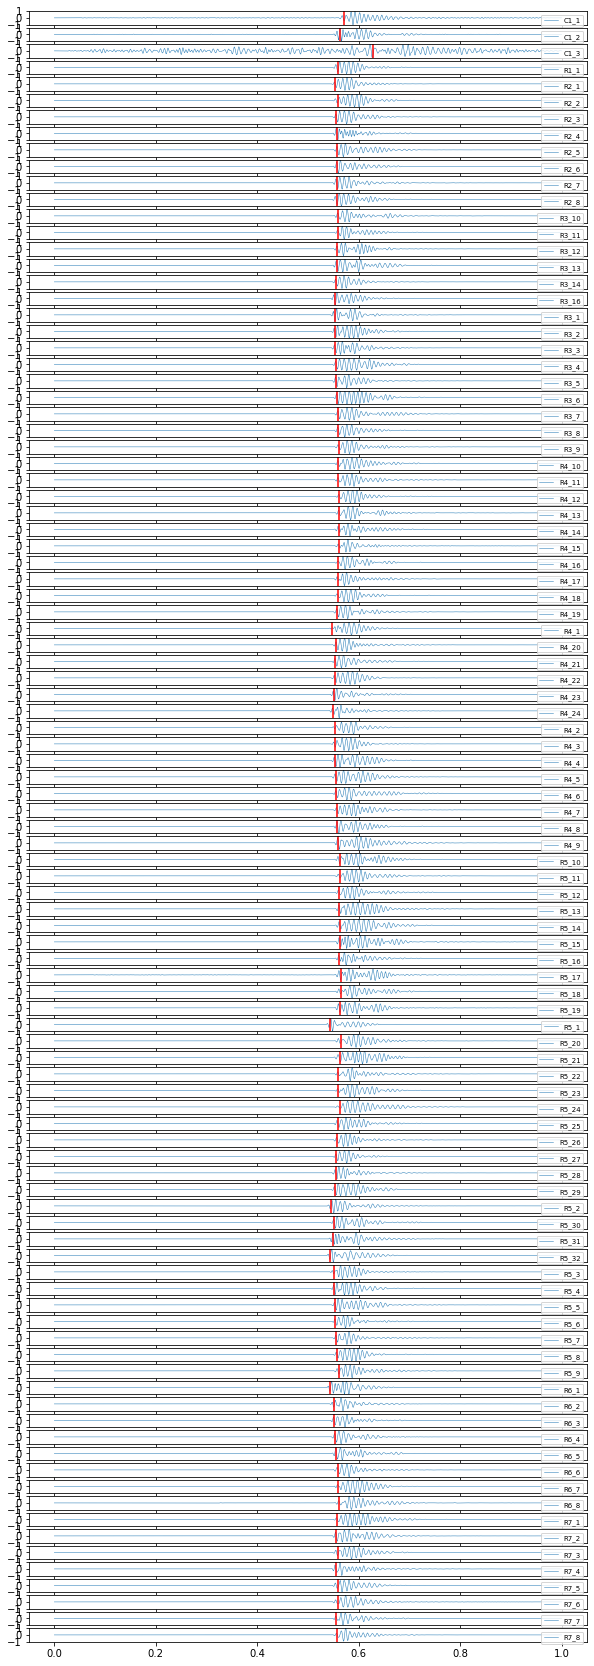

In [9]:
from obspy.signal import trigger

## Records
window = 1
window_length = pd.Timedelta(seconds=window)
starttime = starttime = shots['ShotTime'][shots['LocCode'] == event].values[0]-window_length/2 
endtime = starttime+(window_length)

detections = []
names = []
fig = plt.figure(figsize=(10,30))
i=0
for station in np.sort(st_list):
    st  = obspy.read('Ground_coupling/nodes/FF_Vel/' + station, starttime=UTCDateTime(starttime), endtime=UTCDateTime(endtime)) #Seismic
    st.detrend().taper(0.1).filter('bandpass', freqmin=100, freqmax=200).normalize();
    
    detection = trigger.classic_sta_lta(st[0], st[0].stats.sampling_rate*0.01*window, 
                                        st[0].stats.sampling_rate*0.25*window)
    
    ax = fig.add_subplot(len(st_list),1,i+1)
    name = st[0].stats.network + '_' + st[0].stats.station
    ax.plot(st[0].times(), st[0].data, label=name, linewidth=0.5)
    ax.axvline(np.argmax(detection)/st[0].stats.sampling_rate, color='red')
    ax.legend(fontsize=7)
    ax.set_ylim(ymin=-1,ymax=1)
    detections.append(np.argmax(detection))
    names.append(name)
    i+=1
print(names[np.argmin(detections)])


### TESTING AREA

In [10]:
indexes = []
delta_t = []
for station_from, group_from in cc_hyp_full.groupby('station_from'):
     for station_to, group_to in group_from.groupby('station_to'):
        if [station_to, station_from] not in indexes:
            print([station_from, station_to, ])
            print(np.average(group_to['delay'], weights=group_to['corr']))
            indexes.append([station_from, station_to])
            delta_t.append(np.average(group_to['delay'], weights=group_to['corr']))
t_est = calc_t_est(indexes, delta_t)
delays_hyp = [t[0] for t in t_est]

# print(delta_t)

delays_hyp

['HYP.01', 'HYP.02']
-0.00419259635105
['HYP.01', 'HYP.03']
-0.00311286859571
['HYP.01', 'HYP.04']
-0.00166341697787
['HYP.02', 'HYP.03']
0.00234975467536
['HYP.02', 'HYP.04']
0.00307537408183
['HYP.03', 'HYP.04']
0.0034082725054


[-0.0022422204811578337,
 0.0024044312770611165,
 0.0010428466064368069,
 -0.0012050574023400899]

In [11]:
indexes = [['R1', 'R2'], ['R1', 'R3'],['R1', 'R4'], ['R2', 'R3'], ['R2','R4'], ['R3', 'R4']]
calc_t_est(indexes, [35,60,35,35,0,-35])

array([[ 32.5],
       [  0. ],
       [-32.5],
       [  0. ]])

In [12]:
station = 'R5_1'
st  = obspy.read('Ground_coupling/nodes/FF_Vel/2019_134_'+station+'VEL.mseed') #Seismic

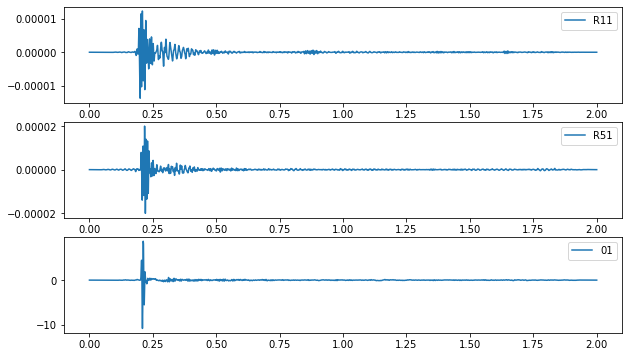

In [13]:
shots     = pd.read_pickle('shots.pkl')
starttime = pd.Timestamp('2019-05-14 13:41:09.75')
endtime = starttime+pd.Timedelta(seconds=2)
# Data selection

st0_win = st0.copy().trim(starttime=UTCDateTime(starttime), endtime=UTCDateTime(endtime))
st_win  = st.copy().trim(starttime=UTCDateTime(starttime), endtime=UTCDateTime(endtime))
hyp_win = hyp.copy().trim(starttime=UTCDateTime(starttime), endtime=UTCDateTime(endtime))

freqmin=10
freqmax=200

st0_win.detrend();
st_win.detrend();
hyp_win.detrend();

st0_win.taper(0.1);
st_win.taper(0.1);
hyp_win.taper(0.1);

st0_win.filter('bandpass', freqmin=freqmin, freqmax=freqmax);
st_win.filter('bandpass', freqmin=freqmin, freqmax=freqmax);
hyp_win.filter('bandpass', freqmin=freqmin, freqmax=freqmax);

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(311)
ax1.plot(st0_win[0].times(), st0_win[0].data, label=st0_win[0].stats.network + st0_win[0].stats.station)
ax2 = fig.add_subplot(312)
ax2.plot(st_win[0].times(), st_win[0].data,  label=st_win[0].stats.network + st_win[0].stats.station)
ax3 = fig.add_subplot(313)
ax3.plot(hyp_win[0].times(), hyp_win[0].data, label=hyp_win[0].stats.location)
ax1.legend()
ax2.legend()
ax3.legend()

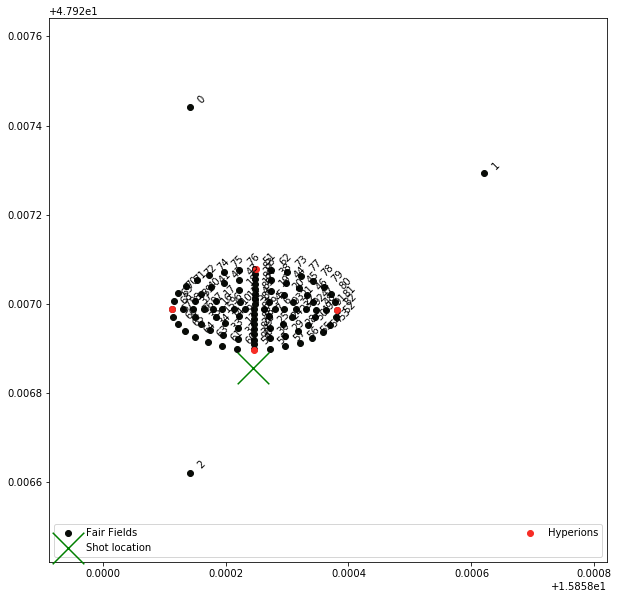

In [14]:
plt.figure(figsize=(10,10))
event = 'H7_1'
x_shot = shots['lon'][shots['LocCode'] == event].values[0]
y_shot = shots['lat'][shots['LocCode'] == event].values[0]
cc_ff_rings = cc_ff#[~cc_ff['station'].isin(['C1.1', 'C1.2', 'C1.3'])]

x_seismic = cc_ff_rings.groupby('station').mean()['lon']
y_seismic = cc_ff_rings.groupby('station').mean()['lat']
z_seismic = np.asarray([np.average(group['delay_Z'], weights=group['corr_Z']) for name, group in 
                        cc_ff_rings.groupby('station')])

plt.scatter(x=x_seismic, y=y_seismic, color=c_seismic, label='Fair Fields')
plt.scatter(x=x_shot,    y=y_shot,    color=c_shot, marker='x', s=1e3, label='Shot location')
plt.scatter(x=x_hyp,     y=y_hyp,     color=c_hyp, label='Hyperions')
for i in range(0,len(x_seismic)):
        plt.text(x=x_seismic[i]+0.00001,y=y_seismic[i] + 0.00001,s=i,rotation=45);

# plt.scatter(x=[x_seismic['R1.1'], x_seismic[station.replace('_','.')]], 
#             y =[y_seismic['R1.1'], y_seismic[station.replace('_','.')]], 
#             color = c_stations, marker="*", label='Stations selected', s=1e2)

# for i in range(0,len(cc_ff_rings.groupby('station').mean())):
#     plt.text(x_seismic[i]+0.0000025,y_seismic[i]+0.0000025, s=str(i))
plt.xlim(x_seismic.min()-0.0002, x_seismic.max()+0.0002)
plt.ylim(y_seismic.min()-0.0002, y_seismic.max()+0.0002)
plt.legend(mode="expand", loc=4, ncol=2)